In [356]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint

In [357]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [358]:
datagen = ImageDataGenerator(rescale=1.0 / 255.0)
train_generator = datagen.flow_from_directory(
    #'/mnt/d/My projects/programs/Python projects/AItry2/res/archive/dogImages/dogImages/train',
    'res\\archive_150x150_30class\dogImages\dogImages\\train',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical')

valid_generator = datagen.flow_from_directory(
    #'/mnt/d/My projects/programs/Python projects/AItry2/res/archive/dogImages/dogImages/valid',
    'res\\archive_150x150_30class\dogImages\dogImages\\valid',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

Found 1720 images belonging to 30 classes.


Found 211 images belonging to 30 classes.


In [359]:
model = keras.Sequential([
        Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(units=50, activation="relu"),
        Dropout(0.5),
        Dense(units=50, activation="relu"),
        Dropout(0.5),
        Dense(units=30, activation="softmax")
    ])

model.summary()

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 150, 150, 8)       224       
                                                                 
 max_pooling2d_93 (MaxPooli  (None, 75, 75, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_89 (Conv2D)          (None, 75, 75, 16)        1168      
                                                                 
 max_pooling2d_94 (MaxPooli  (None, 37, 37, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_90 (Conv2D)          (None, 37, 37, 16)        2320      
                                                                 
 max_pooling2d_95 (MaxPooli  (None, 18, 18, 16)      

In [360]:
checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

In [367]:
model.load_weights("best_weights.h5")

In [366]:
model_result = model.fit(train_generator,
                         epochs=20,
                         validation_data=valid_generator,
                         #validation_data=(valid_input, valid_output)
                         callbacks=[checkpoint]
                         )

Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 2.8492 - accuracy: 0.1390
Epoch 1: val_loss improved from 2.79036 to 2.75075, saving model to best_weights.h5
27/27 [==============================] - 3s 108ms/step - loss: 2.8492 - accuracy: 0.1390 - val_loss: 2.7507 - val_accuracy: 0.1943
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 2.8176 - accuracy: 0.1320
Epoch 2: val_loss improved from 2.75075 to 2.74825, saving model to best_weights.h5
27/27 [==============================] - 3s 115ms/step - loss: 2.8176 - accuracy: 0.1320 - val_loss: 2.7482 - val_accuracy: 0.1801
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 2.7445 - accuracy: 0.1616
Epoch 3: val_loss improved from 2.74825 to 2.69294, saving model to best_weights.h5
27/27 [==============================] - 3s 111ms/step - loss: 2.7445 - accuracy: 0.1616 - val_loss: 2.6929 - val_accuracy: 0.1991
Epoch 4/20
27/27 [==============================] - ETA: 0s - loss: 2.714

KeyboardInterrupt: 

In [369]:
model.evaluate(train_generator)

27/27 [==============================] - 9s 359ms/step - loss: 2.1527 - accuracy: 0.3163


[2.1526753902435303, 0.3162790834903717]

In [370]:
test_generator = datagen.flow_from_directory(
    'res\\archive_150x150_30class\dogImages\dogImages\\test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

model.evaluate(test_generator)

Found 221 images belonging to 30 classes.


7/7 [==============================] - 1s 175ms/step - loss: 2.4917 - accuracy: 0.2217


[2.4916794300079346, 0.22171945869922638]

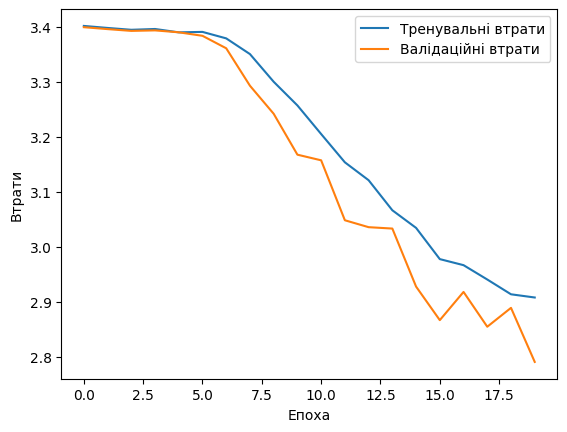

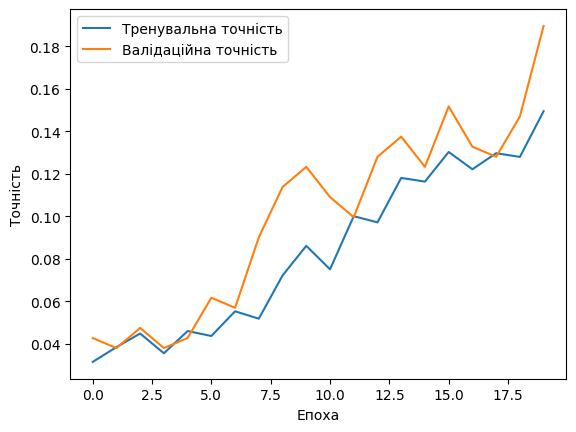

In [364]:
plt.plot(model_result.history['loss'], label='Тренувальні втрати')
plt.plot(model_result.history['val_loss'], label='Валідаційні втрати')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()
plt.show()

plt.plot(model_result.history['accuracy'], label='Тренувальна точність')
plt.plot(model_result.history['val_accuracy'], label='Валідаційна точність')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()
plt.show()